In [708]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from hb import transfer
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [709]:
# model to be studied
def model(u):
    return np.array([np.tanh(3*u)+1, 9/np.cosh(3*u)**2])

In [710]:
class Coef():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx, 1))
        for i in range(Nx):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

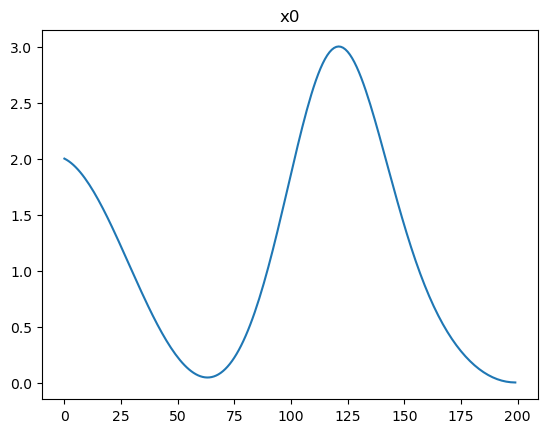

In [711]:
Nx = 200
Nt = 50
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
C = Coef(Nx, 0.1, 3, 0.8e-1, model=model)
x0 = np.zeros(Nx)
x0 = np.exp(-x)*np.cos(3*np.pi/2*x)**2
x0 += np.exp(-(0.6-x)**2*50)
x0 *= 2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]
plt.title('x0')
plt.plot(x0)
plt.show()

In [712]:
prob = transfer(C, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
#solver_n.setSources([0.7], [-0.2])
nl_solver = newton()
solver_n.setSolver(nl_solver)

In [713]:
solver_n.setInitial(x0)
X, mes, t = test(solver_n, sample_size = 1)

test started
verdict : OK
mean time : 12.442675590515137
mean newton iterations:  13.96


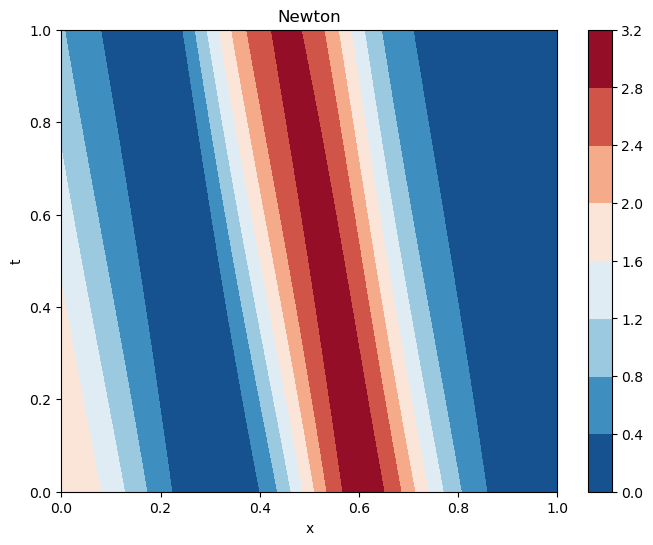

In [714]:
wp.show_res(solver_n)

In [715]:
prob = transfer(C, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setInitial(x0)
Nd = 5
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion)
solver.setSolver(nl_solver)

In [716]:
X, mes, t = test(solver, sample_size=1)

test started
verdict : OK
mean time : 10.747754096984863
mean aspen iterations:  3.0


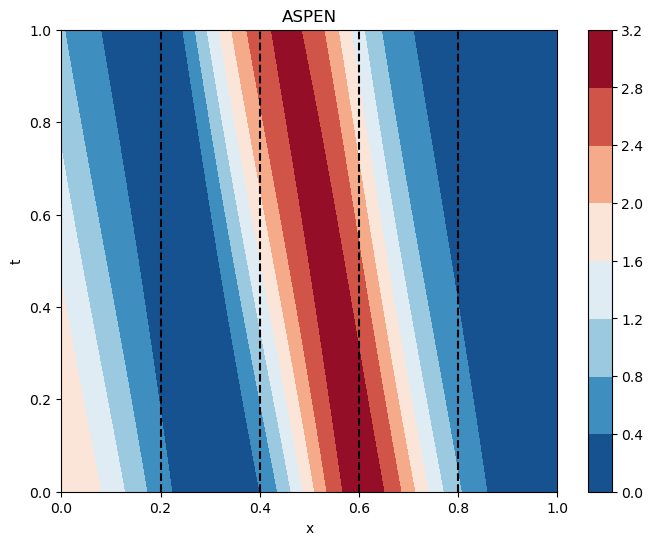

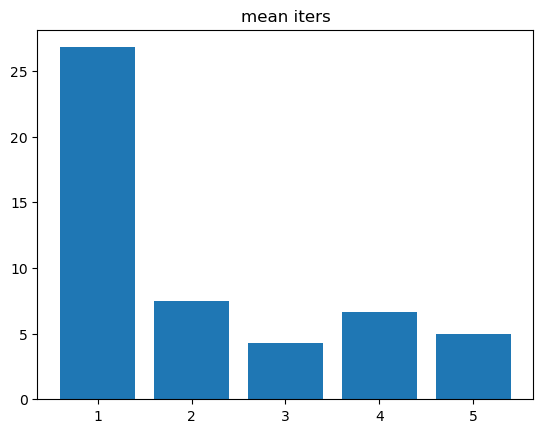

In [717]:
wp.show_res(solver, save='hyper1')
wp.bar_loc(solver, Nd, save='hyper2')

--time comparision--
newton : 12.394831657409668
aspen : 10.595922708511353


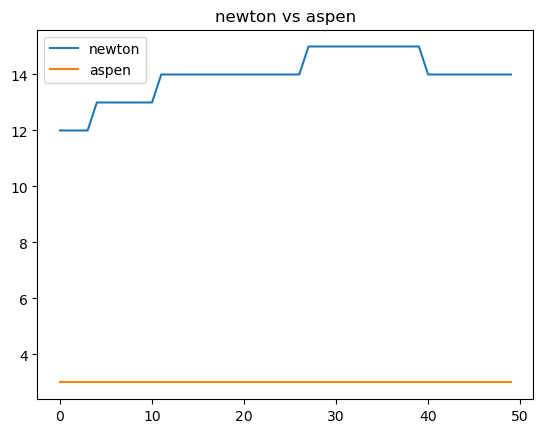

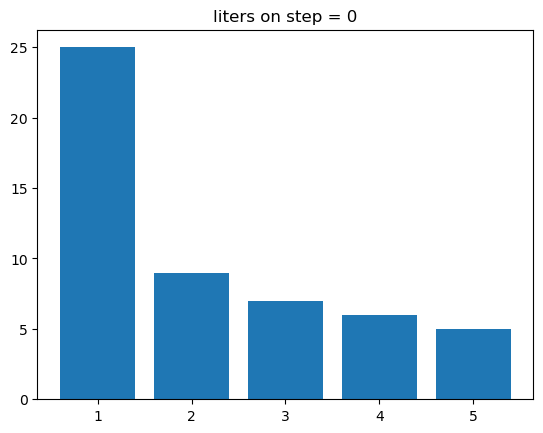

In [718]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp')
wp.bar_loc_step(solver, Nd, 0)

In [ ]:
time = np.zeros((10, 2))

Nx = 200
Nd = 5

x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.2e-1, model=model)
x0 = np.exp(-x)*np.cos(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)

nl_new = newton()
partion = pt.partion_equally(Nx, Nd)
nl_asp = aspen(Nd, partion) 

for i in range(10):
    Nt = 50*(1+i)
    param ={'Nx': Nx, 'Nt' : Nt}
    prob = transfer(C, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setInitial(x0)
    
    solver.setSolver(nl_new)
    _, mes, t = test(solver, sample_size=1)
    t = wp.tim(solver.timelog)
    time[i, 0] = np.copy(t)
    if(mes != 'OK'):
        print(mes, i) 
        
    prob = transfer(C, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setInitial(x0)
    solver.setSolver(nl_asp)
    _, mes, t = test(solver, sample_size=1)
    t = wp.tim(solver.timelog)
    time[i, 1] = np.copy(t)
    if(mes != 'OK'):
        print(mes, i)

[[10.87223244 10.30753207]
 [ 8.60140538 17.24413824]
 [ 9.50255919 21.45538878]
 [ 9.90457678 20.51654816]
 [11.10183644 24.57856441]
 [17.01386738 35.76215029]
 [17.49892354 36.15015888]
 [17.24468446 42.66874838]
 [15.13775063 44.44656277]
 [14.7457962  45.46250391]]


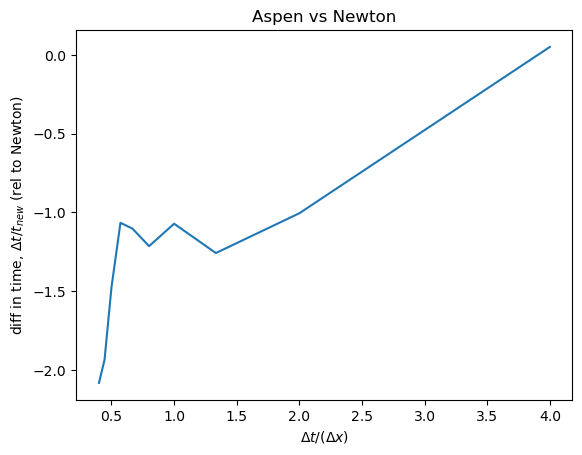

In [705]:
print(time)
dif = (+time[:, 0] - time[:, 1])/time[:, 0]
curant = Nx/(50*np.arange(1, 11))

plt.title('Aspen vs Newton')
plt.xlabel('$\Delta t/(\Delta x)$')
plt.ylabel('diff in time, $\Delta t/t_{new}$ (rel to Newton)')
plt.plot(curant, dif)
plt.savefig('comppp2', dpi = 300)
plt.show()